In [68]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
from folium.plugins import MarkerCluster
import datetime

In [484]:
def get_data(n=500000):

    df = pd.read_csv('bird_data.csv')
    df.drop(['code', 'captive'], axis=1, inplace=True)

    temp_df = df.head(n)

    new_df = add_lat_long(temp_df)
    new_df['count'] = 1
    new_df['grid_location'] = 0
    new_df.drop(['location'], axis=1, inplace=True)
    return new_df

In [70]:
def add_lat_long(df):
    loc_array = df['location']
    
    loc_list= []
    for i in loc_array:
        loc_list.append(ast.literal_eval(i))
    
    df = pd.concat([df, pd.DataFrame(loc_list)], axis=1)
    df['latitude'] = df['latitude'].round(5)
    df['longitude'] = df['longitude'].round(5)
    return df

In [71]:
def get_geojson_grid(upper_right, lower_left, n=6):
    """Returns a grid of geojson rectangles, and computes the exposure in each section of the grid based on the vessel data.

    Parameters
    ----------
    upper_right: array_like
        The upper right hand corner of "grid of grids" (the default is the upper right hand [lat, lon] of the USA).

    lower_left: array_like
        The lower left hand corner of "grid of grids"  (the default is the lower left hand [lat, lon] of the USA).

    n: integer
        The number of rows/columns in the (n,n) grid.

    Returns
    -------

    list
        List of "geojson style" dictionary objects   
    """

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes

In [142]:
def add_grid_location(df, n=42):
    
    '''
    Assigns each data point to a location on the grid according to its lat/long
    '''
    
    top_right = [df['latitude'].max(), df['longitude'].max()]
    top_left = [df['latitude'].min(), df['longitude'].min()]
    
    grid = get_geojson_grid(top_right, top_left, n)
    
    for i, box in enumerate(grid):
        upper_right = box["properties"]["upper_right"]
        lower_left = box["properties"]["lower_left"]
    
        mask = (
            (df.latitude <= upper_right[1]) & (df.latitude >= lower_left[1]) &
            (df.longitude <= upper_right[0]) & (df.longitude >= lower_left[0])
           )
    
        column_name = 'grid_location'
        df.loc[mask, column_name] = i
    
    return df

In [73]:
def add_time_chunk(df):
    df['time_chunk'] = 0
    for i, time in enumerate(df['time'].unique()):
        df['time_chunk'][df['time'] == time] = i
    return df

In [74]:
def add_day_of_week(df):
    df['date'] = pd.to_datetime(df['time']).dt.round("D")
    df['day_of_week'] = df['date'].dt.day_name()
    
    return df

In [75]:
def add_rounded_time(df, interval=15):
    '''
    Adds a column with the rounded time to the interval specified.
    
    '''
    df['rounded_time'] = pd.to_datetime(df['time']).dt.round('15min')  
    #df['rounded_time'] = pd.to_datetime(df['time']).dt.round("Min").apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*round((float(dt.minute) + float(dt.second)/60) / interval)))
    #df['rounded_time'] = pd.Series([val.time() for val in df['rounded_time']])
    
    df_time = pd.to_datetime(df["rounded_time"])

    df['rounded_time'] = df_time.dt.hour*60+df_time.dt.minute*60 + df_time.dt.second
    
    
    return df

In [76]:
def add_wait_time(df):
    '''
    Adds a column that tells how long a scooter has been waiting in a location
    
    '''
    final_df = pd.DataFrame()
    for i in range(len(df['id'].unique())):
        
        # set this df to all the data points with the same id
        temp_df = df[df['id'] == df['id'].unique()[i]]
        
        
        for j in range(len(temp_df['latitude'].unique())):
            
            # set this df to iterate through all of the unique lats from the temp data set
            same_lat_long_df = temp_df[temp_df['latitude'] == temp_df['latitude'].iloc[j]]
        
            # create new column 'wait_time' that is the difference in time between the first and last datapoints
            same_lat_long_df['wait_time'] = pd.to_datetime(same_lat_long_df['time']).iloc[-1] - pd.to_datetime(same_lat_long_df['time']).iloc[0]
            
            #append the new column to the output df
            final_df = final_df.append(same_lat_long_df)
    
    return final_df


In [77]:
def drop_repeated_data(df):
    '''
    Removes repeated data based on id and rounded_time - this should cut the data down by more than half
    '''
    
    df.drop_duplicates(subset=['id','rounded_time'], keep='first', inplace=True)
    return df

In [485]:
df = get_data()
df = add_rounded_time(df)
df = drop_repeated_data(df)
df.head()

,battery_level,id,time,latitude,longitude,count,grid_location,rounded_time
0,44,cd6ff74b-cba6-49fe-b115-cec6066fe919,2018-11-09 00:55:30.991958,37.84524,-122.29350,1,0,60
1,48,e20d8a6c-2453-494a-a083-00bad445b189,2018-11-09 00:55:30.991958,37.84600,-122.29569,1,0,60
2,48,c8f9bed6-48bd-405d-a290-84bd0148a700,2018-11-09 00:55:30.991958,37.84543,-122.28824,1,0,60
3,38,b7ac0ffe-77dd-40dc-82f1-cb59e0f6fb6b,2018-11-09 00:55:30.991958,37.84618,-122.28023,1,0,60
4,81,7e9d6f7f-90ba-4205-b040-1c5025512467,2018-11-09 00:55:30.991958,37.82930,-122.28083,1,0,60


In [315]:
len(df)

1320

In [486]:
df = add_day_of_week(df)
df = add_grid_location(df)
#df = add_wait_time(df)
df.head()

,battery_level,id,time,latitude,longitude,count,grid_location,rounded_time,date,day_of_week
0,44,cd6ff74b-cba6-49fe-b115-cec6066fe919,2018-11-09 00:55:30.991958,37.84524,-122.29350,1,1347,60,2018-11-09,Friday
1,48,e20d8a6c-2453-494a-a083-00bad445b189,2018-11-09 00:55:30.991958,37.84600,-122.29569,1,1388,60,2018-11-09,Friday
2,48,c8f9bed6-48bd-405d-a290-84bd0148a700,2018-11-09 00:55:30.991958,37.84543,-122.28824,1,1349,60,2018-11-09,Friday
3,38,b7ac0ffe-77dd-40dc-82f1-cb59e0f6fb6b,2018-11-09 00:55:30.991958,37.84618,-122.28023,1,1393,60,2018-11-09,Friday
4,81,7e9d6f7f-90ba-4205-b040-1c5025512467,2018-11-09 00:55:30.991958,37.82930,-122.28083,1,1141,60,2018-11-09,Friday


In [293]:
df.isnull().values.any()

False

In [388]:
def grid_count(df, n=42):
    '''
    For a given time, day of the week create df of number of scooters in each grid location
    '''
    
    new_df = pd.DataFrame()
    for unique_date in df['date'].unique():
        for unique_rounded_time in df['rounded_time'].unique():
            for unique_grid_location in range(n**2):
                if ((df['date'] == unique_date) & (df['rounded_time'] == unique_rounded_time) & (df['grid_location'] == unique_grid_location)).any():
                    continue
                else:
                    #print (unique_grid_location)
                    new_df = new_df.append({'rounded_time':unique_rounded_time, 'grid_location':unique_grid_location, 'date':unique_date}, ignore_index=True)
    new_df['grid_location'] = new_df['grid_location'].astype(int)                
    
    df = df.groupby(['rounded_time', 'grid_location', 'day_of_week', 'date']).size().reset_index(name='counts')
    df3 = pd.concat([df,new_df])
    df3 = df3.fillna(0)
    df3 = df3.sort_values(by=['grid_location', 'rounded_time'])
    #for a given date and rounded time - check to see if there is a grid location, if not set count to 0.
    
    #df = df.groupby(['grid_location']).agg(['count'])
    return df3

In [487]:
new_df = grid_count(df)
new_df.info()
 #df3 = pd.concat([df,new_df])
 #df3.drop_duplicates(subset=['grid_location', 'col3'], inplace=True, keep='last')
#new_df = new_df.groupby(['rounded_time', 'grid_location', 'date'], as_index=False)[['count']].sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28224 entries, 0 to 19499
Data columns (total 5 columns):
counts           28224 non-null float64
date             28224 non-null datetime64[ns]
day_of_week      28224 non-null object
grid_location    28224 non-null int64
rounded_time     28224 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.3+ MB


/Users/johnhayes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [173]:
#new_df = new_df.groupby(['rounded_time', 'grid_location', 'date'])['count'].sum()
new_df.copy()
new_df['time_total'] = new_df['rounded_time']+new_df['date']
merge_df = pd.merge(new_df,new_df,how='left', left_on='grid_location', right_on='grid_location')
double_merge = merge_df[(merge_df['time_total_x']>merge_df['time_total_y'])]

double_merge[double_merge['grid_location']==0]
#merge_df


,rounded_time_x,grid_location,date_x,count_x,time_total_x,rounded_time_y,date_y,count_y,time_total_y
7056,960.0,0,1.541722e+09,0.0,1.541723e+09,60.0,1.541722e+09,0.0,1.541722e+09
14112,1860.0,0,1.541722e+09,0.0,1.541723e+09,60.0,1.541722e+09,0.0,1.541722e+09
14113,1860.0,0,1.541722e+09,0.0,1.541723e+09,960.0,1.541722e+09,0.0,1.541723e+09
21168,2760.0,0,1.541722e+09,0.0,1.541724e+09,60.0,1.541722e+09,0.0,1.541722e+09
21169,2760.0,0,1.541722e+09,0.0,1.541724e+09,960.0,1.541722e+09,0.0,1.541723e+09
21170,2760.0,0,1.541722e+09,0.0,1.541724e+09,1860.0,1.541722e+09,0.0,1.541723e+09


In [158]:
#For Categorical - set count to 1 or 0 depending on if there are any scooters there

#new_df.loc[(new_df['count'] >= 1), 'count'] =1

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

0.9240362811791383
0.6008583690987125


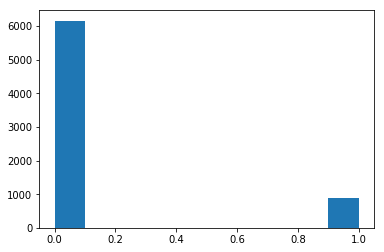

In [161]:
xdf = new_df.drop(['date'], axis=1)


neigh = KNeighborsClassifier(n_neighbors=3)

y = xdf['count']
X = xdf.drop('count', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

#print(X)

neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print(neigh.score(X_test, y_test))
print(recall_score(y_test, y_pred))
plt.hist(xdf['count']);

In [133]:
def MVP(df):
    '''
    even more mvp than mvp
    '''
    
    y = df['count']
    X = df.drop('count', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    
    
    linreg=LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    
    #print(y_pred - y_test)
    print (np.shape(y_pred), np.shape(y_test))
    
    print(recall_score(y_test, y_pred))
    return linreg.score(X_test, y_test)


In [134]:
xdf = new_df.drop(['date'], axis=1)

In [135]:
MVP(xdf)

(1764, 1) (1764, 1)


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

y = df['count']
X = df.loc[:, df.columns != 'count']

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)  
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc([train_index]), X.iloc([test_index])
    y_train, y_test = y[train_index], y[test_index]


In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4],[1, 2], [3, 4],[3, 4],[1, 2],     [3, 4],[3, 4],[1, 2], [3, 4] ])
y = np.array([1, 2, 3, 4, 5, 6,7,8,9,10,11,12])
tscv = TimeSeriesSplit(n_splits=int((len(y)-3)/3))
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

    #To get the indices 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [490]:
new_df['date'] =(new_df['date'] - datetime.datetime(1970,1,1)).dt.total_seconds()

In [488]:
new_df.head()

,counts,date,day_of_week,grid_location,rounded_time
0,0.0,2018-11-09,0,0,60.0
13016,0.0,2018-11-10,0,0,60.0
6183,0.0,2018-11-09,0,0,120.0
19500,0.0,2018-11-10,0,0,120.0
7724,0.0,2018-11-09,0,0,900.0


This adds a new column containing all of the scooter ids in a grid at a time and date.

In [396]:
group_df = df.groupby(['grid_location', 'date', 'rounded_time'])['id'].apply(list)

In [397]:
group_df.head()

grid_location  date        rounded_time
31             2018-11-09  60                         [fdd38cba-5729-46c9-83bd-d7f4af570917]
                           960                        [fdd38cba-5729-46c9-83bd-d7f4af570917]
36             2018-11-09  60                         [d58a7857-64f7-46e0-8e00-2ae5e486aaa8]
                           960                        [d58a7857-64f7-46e0-8e00-2ae5e486aaa8]
81             2018-11-09  60              [db9546e7-aa7a-46de-8f69-8db5a0a25cc4, 131b557...
Name: id, dtype: object

In [491]:
group_df
g = df.groupby(['grid_location', 'date', 'rounded_time'])['id'].apply(list).reset_index(name='id_list')
#g['size'] = df.groupby(['grid_location', 'date', 'rounded_time'])['id'].transform('size')
g['date'] =(g['date'] - datetime.datetime(1970,1,1)).dt.total_seconds()
#new_df
merger_df = pd.merge(new_df, g, on=['grid_location', 'date', 'rounded_time'], how='outer')
merger_df

,counts,date,day_of_week,grid_location,rounded_time,id_list
0,0.0,1.541722e+09,0,0,60.0,NaN
1,0.0,1.541808e+09,0,0,60.0,NaN
2,0.0,1.541722e+09,0,0,120.0,NaN
3,0.0,1.541808e+09,0,0,120.0,NaN
4,0.0,1.541722e+09,0,0,900.0,NaN
5,0.0,1.541808e+09,0,0,900.0,NaN
6,0.0,1.541722e+09,0,0,960.0,NaN
7,0.0,1.541808e+09,0,0,960.0,NaN
8,0.0,1.541722e+09,0,0,1800.0,NaN
9,0.0,1.541808e+09,0,0,1800.0,NaN


In [492]:
isnull = merger_df.id_list.isnull()

merger_df.loc[isnull, 'id_list'] = [ [[]] * isnull.sum() ]


In [493]:
merger_df['time'] = merger_df['date'] + merger_df['rounded_time']

In [402]:
#merger_df = merger_df.drop(['battery_level', 'day_of_week', 'id', 'latitude', 'longitude'], axis =1)

In [504]:
merger_df.sort_values(by=['grid_location', 'time'], inplace=True)
merger_df.sort_values(by='counts', ascending=False).head(200)

,counts,date,day_of_week,grid_location,rounded_time,id_list,time
9585,197.0,1.541808e+09,Saturday,599,60.0,"[3d3cd4f1-c6fc-402d-80a5-2a79acba4a41, 71d3598...",1.541808e+09
9591,196.0,1.541808e+09,Saturday,599,960.0,"[ae9f8b88-2dfc-47a1-a1bc-db79596a76aa, 71d3598...",1.541809e+09
9596,168.0,1.541808e+09,Saturday,599,2700.0,"[3d3cd4f1-c6fc-402d-80a5-2a79acba4a41, d6048b3...",1.541811e+09
9595,161.0,1.541808e+09,Saturday,599,1860.0,"[63e24b5a-426e-4cf2-bf97-0b5468194db8, ef3c8d5...",1.541810e+09
9592,66.0,1.541808e+09,Saturday,599,1800.0,"[63e24b5a-426e-4cf2-bf97-0b5468194db8, 6e8ece3...",1.541810e+09
10886,24.0,1.541722e+09,Friday,680,960.0,"[55e858bf-28b4-4510-99ee-901508f00a4f, 20eaf5e...",1.541723e+09
10890,24.0,1.541722e+09,Friday,680,1860.0,"[20eaf5e3-dce9-4204-9ce8-5a4b0d1b71ed, 1bc1d1d...",1.541723e+09
12260,23.0,1.541808e+09,Saturday,766,900.0,"[3029fd6c-a9df-4f1e-a895-30631541fe20, f5f1e66...",1.541809e+09
10880,23.0,1.541722e+09,Friday,680,60.0,"[acbfbee4-bee9-40be-8089-1b18f117e349, 019c73f...",1.541722e+09
10894,22.0,1.541722e+09,Friday,680,2760.0,"[019c73f4-7769-4f49-adda-62a2173fafff, 83d4193...",1.541724e+09


In [411]:
for grid_location, g in merger_df.sort_values("time").groupby("grid_location"):
    break

In [412]:
g

,counts,date,day_of_week,grid_location,rounded_time,id_list,time
0,0.0,1.541722e+09,0,0,60.0,[],1.541722e+09
1,0.0,1.541722e+09,0,0,960.0,[],1.541723e+09


In [ ]:
#list(set(list1).intersection(list2))

#Two columns - difference in number of unique scooters in last 15 min.
#            - how many scooters have left in the last 15 min.

#NUMBER IDLE:  len(list(set("current grid at time x") & set("current grid at time x-15")))
#NUMBER TURN OVER: len(list(set("current grid at time x") - set("current grid at time x-15")))

df['num_idle'] = np.where(merger_df[])



In [459]:
df = pd.read_csv('bird_data.csv', nrows=200000)

In [460]:
df["time"] = pd.to_datetime( df.time )

In [461]:
df["location"] = df.location.str.replace("'", "\"").map( lambda x: json.loads(x) )

In [462]:
df["latitude"] = df["location"].map( lambda x:x["latitude"] )
df["longitude"] = df["location"].map( lambda x:x["longitude"] )


In [464]:
df.head()

,battery_level,captive,code,id,location,time,latitude,longitude
0,44,False,NaN,cd6ff74b-cba6-49fe-b115-cec6066fe919,"{'latitude': 37.845245, 'longitude': -122.2935...",2018-11-09 00:55:30.991958,37.845245,-122.293503
1,48,False,NaN,e20d8a6c-2453-494a-a083-00bad445b189,"{'latitude': 37.846000000000004, 'longitude': ...",2018-11-09 00:55:30.991958,37.846000,-122.295692
2,48,False,NaN,c8f9bed6-48bd-405d-a290-84bd0148a700,"{'latitude': 37.84542833333333, 'longitude': -...",2018-11-09 00:55:30.991958,37.845428,-122.288238
3,38,False,NaN,b7ac0ffe-77dd-40dc-82f1-cb59e0f6fb6b,"{'latitude': 37.84618, 'longitude': -122.28023...",2018-11-09 00:55:30.991958,37.846180,-122.280235
4,81,False,NaN,7e9d6f7f-90ba-4205-b040-1c5025512467,"{'latitude': 37.829296666666664, 'longitude': ...",2018-11-09 00:55:30.991958,37.829297,-122.280830


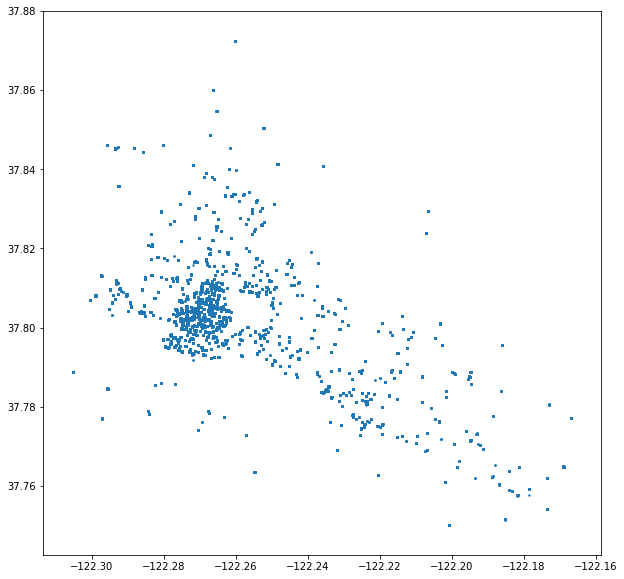

In [463]:
fig, ax = plt.subplots( figsize=(10,10) )
ax.scatter( df["longitude"], df["latitude"], s=2 )